In [2]:
import pathlib
import os
import warnings
warnings.filterwarnings('ignore')

# Change to the project root directory
project_root = pathlib.Path().resolve().parent
os.chdir(project_root)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima.model import ARIMA as Arima
from darts import TimeSeries

# Import Data

In [3]:
data_path = pathlib.Path("data/DCOILWTICO.csv")
print(f"Loading from: {data_path.absolute()}")
print(f"File exists: {data_path.exists()}")

data = pd.read_csv(data_path)
data.rename(columns = {"observation_date" : "date", "DCOILWTICO" : "price"}, inplace  = True)
data["date"] = pd.to_datetime(data["date"])
data = data.set_index("date")
data = data.asfreq('B')
data["price"] = data["price"].fillna(method='ffill')
data["return"] = np.log(data["price"]) - np.log(data["price"].shift(1))
returns = data["return"].replace([np.inf, -np.inf], np.nan).dropna().astype("float32")

Loading from: /Users/victormp/Desktop/ml/ml-project/data/DCOILWTICO.csv
File exists: True


# Split Data

In [4]:
# Three-way split: 60% train, 20% validation, 20% test
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 0.2

train_end = int(len(returns) * train_ratio)
val_end = int(len(returns) * (train_ratio + val_ratio))

# Split the data
y_train = returns.iloc[:train_end]
y_val = returns.iloc[train_end:val_end]
y_test = returns.iloc[val_end:]

# Convert to darts TimeSeries objects
train_series = TimeSeries.from_values(y_train)
val_series = TimeSeries.from_values(y_val)
test_series = TimeSeries.from_values(y_test)

print(f"Train size: {len(train_series)} ({train_ratio*100}%)")
print(f"Validation size: {len(val_series)} ({val_ratio*100}%)")
print(f"Test size: {len(test_series)} ({(1-train_ratio-val_ratio)*100}%)")

Train size: 782 (60.0%)
Validation size: 261 (20.0%)
Test size: 261 (20.0%)


# Plot Data

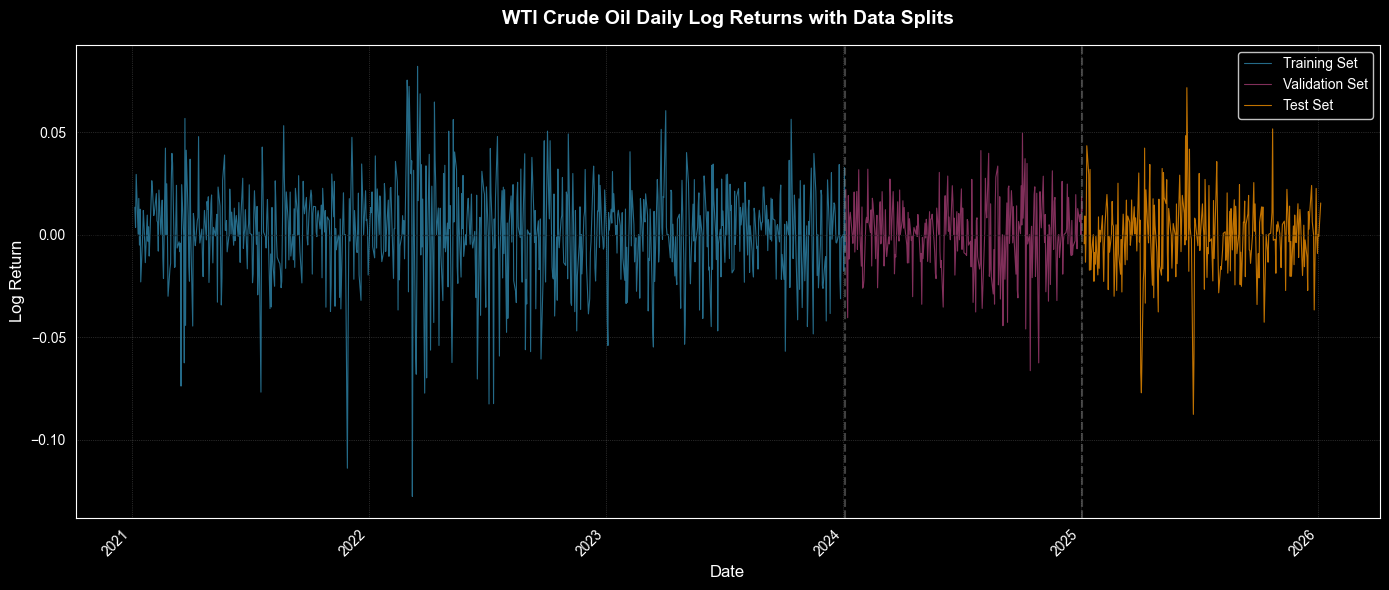

In [5]:
#Plot of returns and data split
fig, ax = plt.subplots(figsize=(14, 6))
#Split the data
train_data = returns.iloc[:train_end]
val_data = returns.iloc[train_end:val_end]
test_data = returns.iloc[val_end:]

#plot each section with different colors
ax.plot(train_data.index, train_data.values, 
        linewidth=0.8, color='#2E86AB', alpha=0.8, label='Training Set')
ax.plot(val_data.index, val_data.values, 
        linewidth=0.8, color='#A23B72', alpha=0.8, label='Validation Set')
ax.plot(test_data.index, test_data.values, 
        linewidth=0.8, color='#F18F01', alpha=0.8, label='Test Set')

#add horizontal line at zero
ax.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.4)

#add vertical lines to separate sections
ax.axvline(x=train_data.index[-1], color='gray', linestyle='--', linewidth=1.5, alpha=0.5)
ax.axvline(x=val_data.index[-1], color='gray', linestyle='--', linewidth=1.5, alpha=0.5)

ax.set_title('WTI Crude Oil Daily Log Returns with Data Splits', 
             fontsize=14, fontweight='bold', pad=15)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Log Return', fontsize=12)
ax.legend(loc='upper right', framealpha=0.95, fontsize=10)
ax.grid(True, alpha=0.3, linestyle=':', linewidth=0.5)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [11]:
#Summary stats
summary_stats = {
    'Mean': returns.mean(),
    'Median': returns.median(),
    'Std. Dev.': returns.std(),
    'Variance': returns.var(),
    'Min': returns.min(),
    'Max': returns.max(),
    'Range': returns.max() - returns.min(),
    'Q1 (25%)': returns.quantile(0.25),
    'Q3 (75%)': returns.quantile(0.75),
    'IQR': returns.quantile(0.75) - returns.quantile(0.25),
    'Skewness': returns.skew(),
    'Kurtosis': returns.kurtosis(),
}

# Display basic statistics
print("\nDESCRIPTIVE STATISTICS:")
print("="*60)
for stat, value in summary_stats.items():
    print(f"{stat:<20} {value:>15.6f}")


DESCRIPTIVE STATISTICS:
Mean                        0.000119
Median                      0.000260
Std. Dev.                   0.022160
Variance                    0.000491
Min                        -0.127771
Max                         0.082141
Range                       0.209912
Q1 (25%)                   -0.011736
Q3 (75%)                    0.013502
IQR                         0.025237
Skewness                   -0.545735
Kurtosis                    2.410638


# AR Model Selection

In [28]:
returns = y_train
print("="*60)
print("AR vs ARMA MODEL COMPARISON")
print("="*60)
print(f"Sample size: {len(returns)}\n")

# Test different combinations
results = []
print(f"{'Model':<15} {'AIC':<12} {'BIC':<12} {'Log-Lik':<12}")
print("-"*60)

#Pure AR models
for p in range(1, 6):
    try:
        model = Arima(returns, order=(p, 0, 0)).fit()
        results.append({
            'model': f'AR({p})',
            'p': p, 'q': 0,
            'aic': model.aic,
            'bic': model.bic,
            'llf': model.llf
        })
        print(f"AR({p}){'':<10} {model.aic:<12.2f} {model.bic:<12.2f} {model.llf:<12.2f}")
    except Exception as e:
        print(f"AR({p}) FAILED: {e}")
        continue

print()

#ARMA models
for p in range(1, 4):
    for q in range(1, 4):
        try:
            model = Arima(returns, order=(p, 0, q)).fit()
            results.append({
                'model': f'ARMA({p},{q})',
                'p': p, 'q': q,
                'aic': model.aic,
                'bic': model.bic,
                'llf': model.llf
            })
            print(f"ARMA({p},{q}){'':<8} {model.aic:<12.2f} {model.bic:<12.2f} {model.llf:<12.2f}")
        except Exception as e:
            print(f"ARMA({p},{q}) FAILED: {e}")
            continue

if len(results) == 0:
    print("\nERROR: No models could be fitted!")
    raise ValueError("Cannot proceed - no models were fitted successfully")

#find best models
results_df = pd.DataFrame(results)
best_aic_idx = results_df['aic'].idxmin()
best_bic_idx = results_df['bic'].idxmin()
best_aic_model = results_df.loc[best_aic_idx, 'model']
best_bic_model = results_df.loc[best_bic_idx, 'model']

print("\n" + "="*60)
print("BEST MODELS:")
print(f"  By AIC: {best_aic_model:<12} (AIC = {results_df.loc[best_aic_idx, 'aic']:.2f})")
print(f"  By BIC: {best_bic_model:<12} (BIC = {results_df.loc[best_bic_idx, 'bic']:.2f})")
print("="*60)

#Check if ARMA is better
best_ar_bic = results_df[results_df['q'] == 0]['bic'].min()
best_arma_bic = results_df[results_df['q'] > 0]['bic'].min()

print("\nCONCLUSION:")
if best_arma_bic < best_ar_bic:
    improvement = best_ar_bic - best_arma_bic
    print(f"  ARMA fits better than pure AR")
    print(f"  BIC improvement: {improvement:.2f}")
    print(f"  Best model: {best_bic_model}")
else:
    print(f"  Pure AR is sufficient")
    best_ar_idx = results_df[results_df['q']==0]['bic'].idxmin()
    print(f"  Best model: {results_df.loc[best_ar_idx, 'model']}")
print("="*60)

# Fit and diagnose best model
print(f"\nFitting best model: {best_bic_model}")

# Extract p and q properly
best_p = int(results_df.loc[best_bic_idx, 'p'])
best_q = int(results_df.loc[best_bic_idx, 'q'])

# Now fit the model
final_model = Arima(returns, order=(best_p, 0, best_q)).fit()
print("\nParameter Estimates:")
print(final_model.summary().tables[1])

# Check residuals
residuals = final_model.resid
lb_test = acorr_ljungbox(residuals, lags=[5, 10], return_df=True)
print("\nResidual Diagnostics (Ljung-Box):")
print(lb_test[['lb_stat', 'lb_pvalue']])

if (lb_test['lb_pvalue'] > 0.05).all():
    print("\n Residuals are white noise (model is adequate)")
else:
    print("\n Some autocorrelation remains in residuals")


#Extended Ljung-Box test with 20 lags for autocorrelation
print("\n" + "="*60)
print("Extended Ljung-Box test")
print("="*60)

lb_extended = acorr_ljungbox(residuals, lags=range(1, 21), return_df=True)
print("\nLjung-Box Test Results (lags 1-20):")
print(lb_extended[['lb_stat', 'lb_pvalue']])

# Summary
significant_lags = lb_extended[lb_extended['lb_pvalue'] < 0.05]
if len(significant_lags) == 0:
    print("\n Residuals pass Ljung-Box test at all lags")
else:
    print(f"\n Autocorrelation detected at {len(significant_lags)} lag(s):")
    print(f"  Lags: {list(significant_lags.index)}")

# Store the best model info for later use
best_model_order = (best_p, 0, best_q)
print(f"\nBest model order to use: {best_model_order}")

AR vs ARMA MODEL COMPARISON
Sample size: 782

Model           AIC          BIC          Log-Lik     
------------------------------------------------------------
AR(1)           -3592.01     -3578.03     1799.01     
AR(2)           -3596.57     -3577.93     1802.29     
AR(3)           -3596.24     -3572.93     1803.12     
AR(4)           -3595.69     -3567.72     1803.85     
AR(5)           -3602.80     -3570.17     1808.40     

ARMA(1,1)         -3591.67     -3573.02     1799.83     
ARMA(1,2)         -3598.32     -3575.02     1804.16     
ARMA(1,3)         -3600.18     -3572.21     1806.09     
ARMA(2,1)         -3596.60     -3573.29     1803.30     
ARMA(2,2)         -3595.50     -3567.53     1803.75     
ARMA(2,3)         -3597.11     -3564.47     1805.55     
ARMA(3,1)         -3594.31     -3566.34     1803.16     
ARMA(3,2)         -3592.39     -3559.76     1803.19     
ARMA(3,3)         -3601.89     -3564.60     1808.95     

BEST MODELS:
  By AIC: AR(5)        (AIC = -3602

In [ ]:
# Now fit the model - LB test for AR(5)
final_model = Arima(returns, order=(5, 0, 0)).fit()
print("\nParameter Estimates:")
print(final_model.summary().tables[1])

residuals = final_model.resid

lb_extended = acorr_ljungbox(residuals, lags=range(1, 21), return_df=True)
print("\nLjung-Box Test Results (lags 1-20):")
print(lb_extended[['lb_stat', 'lb_pvalue']])